In [1]:
# Run this once in the notebook environment (comment out afterwards)
# %pip install opencv-python numpy pytesseract matplotlib pyodbc

In [2]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import os
import re
import pyodbc
from datetime import datetime

# ---- Tesseract path ----
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# ---- OCR / camera config ----
CAMERA_INDEX = 1
FIXED_SIZE   = (600, 400)

# ROI for CIN
ROIS = {
    "cin_number": (223, 119, 408, 176),
}

# Confidence threshold (0–1)
CONFIDENCE_THRESHOLD = 0.85

# ---- SQL Server config ----
SQL_CONN_STR = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=RAYEN-MSI\\SQLEXPRESS;'
    'DATABASE=PoulinaTracker;'
    'Trusted_Connection=yes;'
)

# ---- Folders ----
OUTPUT_DIR         = "extracted_fields"
ARCHIVE_OK_DIR     = "archive_ok"
ARCHIVE_REVIEW_DIR = "archive_review"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ARCHIVE_OK_DIR, exist_ok=True)
os.makedirs(ARCHIVE_REVIEW_DIR, exist_ok=True)


In [3]:
import numpy as np
import cv2

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


In [4]:
def capture_image(camera_index=0):
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        raise Exception(f"Cannot open camera with index {camera_index}")
    
    captured_frame = None
    print("Live feed started. Press 's' to capture or 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break
        
        display_frame = frame.copy()
        card_contour = robust_detect_card_contour(frame)
        if card_contour is not None:
            cv2.drawContours(display_frame, [card_contour.astype(int)], -1, (0, 255, 0), 3)
        
        cv2.imshow("Live Feed", display_frame)
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('s'):
            captured_frame = frame.copy()
            print("Frame captured.")
            break
        elif key == ord('q'):
            print("Quitting without capturing.")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    return captured_frame

def crop_and_save_rois(image, rois, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    paths = {}
    for name, (x1, y1, x2, y2) in rois.items():
        roi = image[y1:y2, x1:x2]
        roi_image_path = os.path.join(output_dir, f'{name}.jpg')
        cv2.imwrite(roi_image_path, roi)
        paths[name] = roi_image_path
        # optional preview
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(name)
        plt.axis('off')
        plt.show()
    return paths


In [5]:
def robust_detect_card_contour(frame, min_area=10000, max_area_ratio=0.9, card_aspect_ratio_range=(1.4, 1.8)):
    h, w = frame.shape[:2]
    image_area = h * w
    
    ratio = 500.0 / float(h)
    new_dim = (int(w * ratio), 500)
    resized = cv2.resize(frame, new_dim)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    def find_4corner_contour(edged):
        cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        for c in cnts:
            area = cv2.contourArea(c)
            if area < min_area * (ratio ** 2):
                continue
            if area > image_area * max_area_ratio * (ratio ** 2):
                continue
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                x, y, w_box, h_box = cv2.boundingRect(approx)
                aspect_ratio = float(w_box) / float(h_box) if h_box != 0 else 0
                if (card_aspect_ratio_range[0] <= aspect_ratio <= card_aspect_ratio_range[1] or
                    card_aspect_ratio_range[0] <= (1 / aspect_ratio) <= card_aspect_ratio_range[1]):
                    approx = approx.reshape(4, 2) / ratio
                    return approx
        return None

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 200)
    kernel = np.ones((3, 3), np.uint8)
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    approx = find_4corner_contour(edges_closed)
    if approx is not None:
        return approx
    
    adap = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
    adap_closed = cv2.morphologyEx(adap, cv2.MORPH_CLOSE, kernel, iterations=2)
    approx = find_4corner_contour(adap_closed)
    return approx


In [6]:
def ocr_roi_with_conf(image_path: str):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image from {image_path}")
        return "", 0.0
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # numeric-only OCR (CIN)
    config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789'
    data = pytesseract.image_to_data(
        gray,
        output_type=pytesseract.Output.DICT,
        config=config
    )

    words = []
    confs = []
    for t, c in zip(data["text"], data["conf"]):
        if t.strip() != "" and c != -1:
            words.append(t.strip())
            confs.append(c)

    raw_text = "".join(words)
    avg_conf = (sum(confs) / len(confs) / 100.0) if confs else 0.0

    return raw_text, avg_conf

def normalize_cin(raw_text: str):
    digits = re.sub(r"\D", "", raw_text)
    if len(digits) == 8:
        return digits
    if len(digits) > 8:
        return digits[-8:]
    return None


In [7]:
def get_sql_connection():
    return pyodbc.connect(SQL_CONN_STR)

def get_employee_by_cin(cursor, cin: str):
    cursor.execute(
        "SELECT EmployeeID, FirstName, LastName FROM Employees WHERE CIN_Number = ?",
        cin
    )
    row = cursor.fetchone()
    if not row:
        return None
    return {
        "EmployeeID": row.EmployeeID,
        "FirstName": row.FirstName,
        "LastName": row.LastName
    }

def insert_attendance(cursor,
                      employee_id: int,
                      dt,
                      check_in,
                      status: str,
                      needs_review: bool,
                      source: str = "OCR"):
    """
    Insert a single Attendance row.
    CheckOutTime is left NULL (you can update it later if needed).
    """
    cursor.execute(
        """
        INSERT INTO Attendance
            (EmployeeID, Date, CheckInTime, CheckOutTime,
             Status, Source, NeedsReview, CreatedAt, UpdatedAt)
        VALUES
            (?, ?, ?, NULL, ?, ?, ?, GETDATE(), GETDATE())
        """,
        employee_id,
        dt,
        check_in,
        status,
        source,
        1 if needs_review else 0
    )


In [8]:
def process_one_capture():
    # 1) Capture from camera
    raw_image = capture_image(CAMERA_INDEX)
    if raw_image is None:
        print("No image captured.")
        return

    # 2) Detect card & warp
    card_contour = robust_detect_card_contour(raw_image)
    if card_contour is None:
        print("No card detected in the captured image.")
        return

    warped = four_point_transform(raw_image, card_contour)
    warped = cv2.resize(warped, FIXED_SIZE)

    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("Standardized Card Image")
    plt.axis('off')
    plt.show()

    # 3) Crop ROI(s)
    roi_paths = crop_and_save_rois(warped, ROIS, OUTPUT_DIR)

    # 4) OCR CIN ROI
    cin_raw_text, conf = ocr_roi_with_conf(roi_paths["cin_number"])
    cin_norm = normalize_cin(cin_raw_text)

    print(f"Raw CIN text: '{cin_raw_text}'")
    print(f"Normalized CIN: {cin_norm}")
    print(f"OCR avg confidence: {conf:.3f}")

    # 5) Decide NeedsReview
    needs_review = False

    # Condition 1: invalid CIN
    if cin_norm is None:
        needs_review = True
        print("Reason: NO_VALID_CIN")

    # Condition 2: low confidence
    if conf < CONFIDENCE_THRESHOLD:
        needs_review = True
        print(f"Reason: LOW_CONFIDENCE ({conf:.3f})")

    # 6) DB operations
    conn = None
    employee = None
    try:
        conn = get_sql_connection()
        cursor = conn.cursor()

        if cin_norm is not None:
            employee = get_employee_by_cin(cursor, cin_norm)
            if employee is None:
                needs_review = True
                print("Reason: CIN_NOT_IN_EMPLOYEES")

        now = datetime.now()
        dt = now.date()
        check_in_time = now.time().replace(microsecond=0)

        if employee:
            # For now we mark Status as "Present" and rely on NeedsReview flag for issues
            status = "Present"

            insert_attendance(
                cursor,
                employee_id=employee["EmployeeID"],
                dt=dt,
                check_in=check_in_time,
                status=status,
                needs_review=needs_review,
                source="OCR"
            )

            conn.commit()
            print(
                f"Attendance row inserted for EmployeeID={employee['EmployeeID']} "
                f"(NeedsReview={needs_review})."
            )
        else:
            # No employee found → no Attendance insert, manual review only
            print("No employee found with that CIN. No Attendance row inserted, needs manual review.")

    except Exception as e:
        print(f"Database error: {e}")
        if conn:
            conn.rollback()
    finally:
        if conn:
            cursor.close()
            conn.close()

    # 7) Save the original captured image in the appropriate archive folder
    target_folder = ARCHIVE_REVIEW_DIR if (needs_review or employee is None) else ARCHIVE_OK_DIR
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    cin_label = cin_norm if cin_norm is not None else "unknown"
    filename = f"cin_{cin_label}_{ts}.jpg"
    full_path = os.path.join(target_folder, filename)
    cv2.imwrite(full_path, raw_image)
    print(f"Image saved to: {full_path}")


Live feed started. Press 's' to capture or 'q' to quit.
Frame captured.


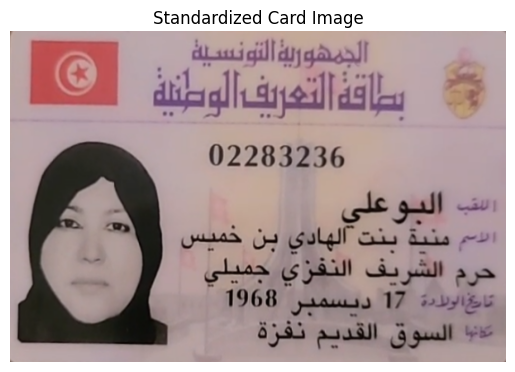

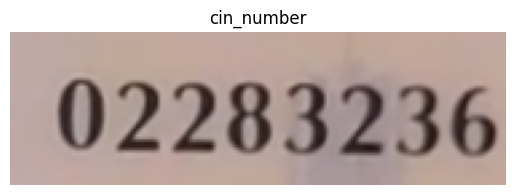

Raw CIN text: '02283236'
Normalized CIN: 02283236
OCR avg confidence: 0.960
Attendance row inserted for EmployeeID=18 (NeedsReview=False).
Image saved to: archive_ok\cin_02283236_20251130_142141.jpg


In [9]:
process_one_capture()
